In [1]:
!pip install matplotlib
!pip install scipy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os


import keras
from keras import Model
import keras.layers as layers
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from keras.callbacks import TensorBoard, EarlyStopping
from keras.utils import image_dataset_from_directory, Sequence
from keras.preprocessing.image import ImageDataGenerator

from keras import datasets
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2023-03-21 19:36:24.002750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 19:36:24.169781: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 19:36:24.872110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 19:36:24.872226: W tensorflow/

In [2]:
img_train_path = os.path.join("DATASET","TRAIN")
img_test_path = os.path.join("DATASET","TEST")
img_SET1_path = os.path.join("DATASET","CROSS/SET1")
img_SET2_path = os.path.join("DATASET","CROSS/SET2")
img_SET3_path = os.path.join("DATASET","CROSS/SET3")
img_SET1_SET2_path = os.path.join("DATASET","CROSS/SET1_SET2")
img_SET1_SET3_path = os.path.join("DATASET","CROSS/SET1_SET3")
img_SET2_SET3_path = os.path.join("DATASET","CROSS/SET2_SET3")

data_gen = ImageDataGenerator(rescale=1./255, fill_mode='reflect')
BATCH_SIZE = 128

raw_generator = data_gen.flow_from_directory(img_train_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET1_generator = data_gen.flow_from_directory(img_SET1_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET2_generator = data_gen.flow_from_directory(img_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
SET3_generator = data_gen.flow_from_directory(img_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET1_generator = data_gen.flow_from_directory(img_SET1_SET2_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET2_generator = data_gen.flow_from_directory(img_SET1_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
CSET3_generator = data_gen.flow_from_directory(img_SET2_SET3_path, target_size=(256,256), batch_size=BATCH_SIZE)
test_generator = data_gen.flow_from_directory(img_test_path, target_size=(256,256), batch_size=BATCH_SIZE)

Found 22564 images belonging to 2 classes.
Found 7447 images belonging to 2 classes.
Found 7672 images belonging to 2 classes.
Found 7445 images belonging to 2 classes.
Found 15119 images belonging to 2 classes.
Found 14892 images belonging to 2 classes.
Found 15117 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [3]:
img, _= next(raw_generator)
print(img.shape)

(128, 256, 256, 3)


In [4]:
def rebuild_model():
    global pretrained_model
    global model
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

    len_trainable_layers = int((14/15*len(pretrained_model.layers)))
    for layer in pretrained_model.layers[0:len_trainable_layers]:
        layer.trainable = False
    model = keras.Sequential()

    model.add(pretrained_model)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.1), metrics=['accuracy'], jit_compile=True)
rebuild_model()
pretrained_model.summary()

2023-03-21 19:36:28.268434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 19:36:28.321085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 19:36:28.321318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 19:36:28.323517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 19:36:28.323674: I tensorflow/compiler/xla/stream_executo

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
          

In [5]:
# reduce time and overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 24,801,282
Trainable params: 5,679,234
Non

Epoch 1/30


2023-03-21 19:36:41.530817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-21 19:36:43.832170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 19:36:43.990649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 128 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
 

  2/118 [..............................] - ETA: 12s - loss: 8333.4199 - accuracy: 0.4766

2023-03-21 19:36:47.110735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  8/118 [=>............................] - ETA: 28s - loss: 2915.0852 - accuracy: 0.5039

2023-03-21 19:36:50.457341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 19:36:50.473252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 15 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

118/118 [==============================] - 67s 466ms/step - loss: 201.1879 - accuracy: 0.5343 - val_loss: 4054.7327 - val_accuracy: 0.5568
Epoch 2/30
118/118 [==============================] - 47s 399ms/step - loss: 0.6912 - accuracy: 0.5471 - val_loss: 0.8677 - val_accuracy: 0.5591
Epoch 3/30
118/118 [==============================] - 47s 400ms/step - loss: 0.6785 - accuracy: 0.5799 - val_loss: 0.9127 - val_accuracy: 0.4531
Epoch 4/30
118/118 [==============================] - 49s 412ms/step - loss: 0.6660 - accuracy: 0.6076 - val_loss: 5.8943 - val_accuracy: 0.4433
Epoch 5/30
118/118 [==============================] - 47s 396ms/step - loss: 0.5820 - accuracy: 0.7036 - val_loss: 0.5588 - val_accuracy: 0.7434
Epoch 6/30
118/118 [==============================] - 47s 402ms/step - loss: 0.4959 - accuracy: 0.7735 - val_loss: 1.7492 - val_accuracy: 0.4449
Epoch 7/30
118/118 [==============================] - 46s 392ms/step - loss: 0.7589 - accuracy: 0.5970 - val_loss: 1.3139 - val_accuracy

2023-03-21 19:44:56.911010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 19:44:57.012349: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 81 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

20/20 [==============================] - 8s 411ms/step - loss: 0.5711 - accuracy: 0.7402
test loss, test acc: [0.571101188659668, 0.7401512265205383]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


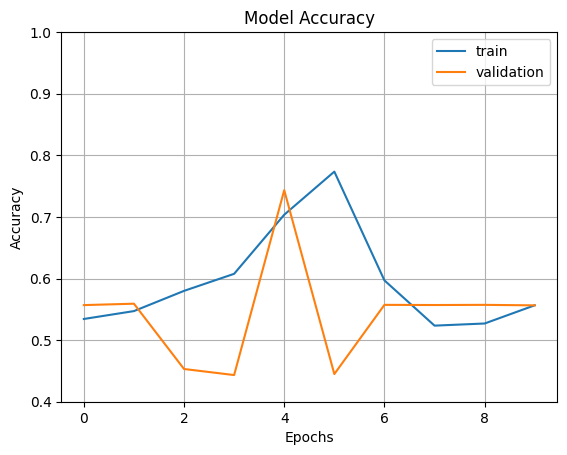

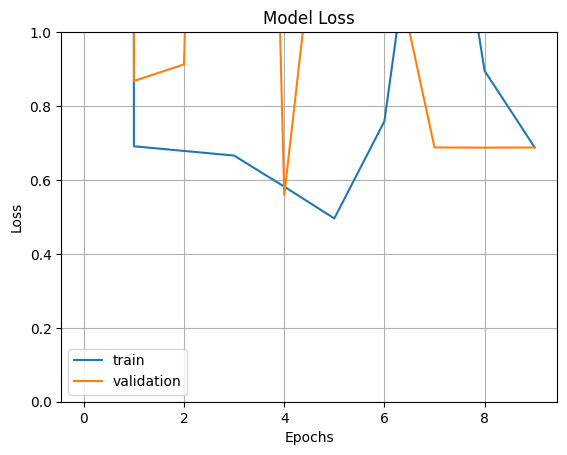

In [6]:
train_generator = CSET1_generator
validation_generator = SET3_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/30
105/116 [==========================>...] - ETA: 3s - loss: 273.9774 - accuracy: 0.5293

2023-03-21 19:45:38.523134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 19:45:38.565371: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 44 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

116/116 [==============================] - 61s 472ms/step - loss: 249.4708 - accuracy: 0.5301 - val_loss: 22.4731 - val_accuracy: 0.5032
Epoch 2/30
116/116 [==============================] - 48s 410ms/step - loss: 0.6950 - accuracy: 0.5341 - val_loss: 0.6885 - val_accuracy: 0.5579
Epoch 3/30
116/116 [==============================] - 48s 412ms/step - loss: 0.6927 - accuracy: 0.5350 - val_loss: 0.6967 - val_accuracy: 0.4439
Epoch 4/30
116/116 [==============================] - 49s 420ms/step - loss: 0.6908 - accuracy: 0.5444 - val_loss: 0.6974 - val_accuracy: 0.5571
Epoch 5/30
116/116 [==============================] - 46s 397ms/step - loss: 0.6948 - accuracy: 0.5359 - val_loss: 0.6869 - val_accuracy: 0.5568
Epoch 6/30
116/116 [==============================] - 48s 418ms/step - loss: 0.6912 - accuracy: 0.5418 - val_loss: 0.6902 - val_accuracy: 0.5576
Epoch 7/30
116/116 [==============================] - 49s 426ms/step - loss: 0.6936 - accuracy: 0.5412 - val_loss: 0.6874 - val_accuracy: 

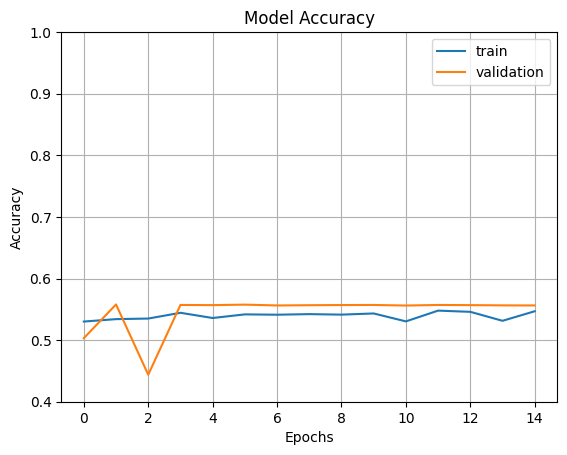

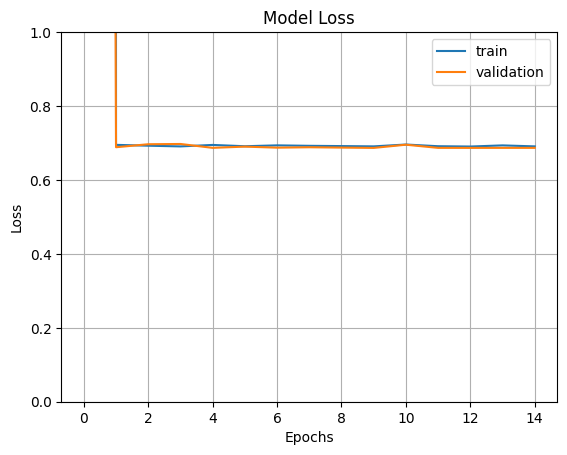

In [7]:
train_generator = CSET2_generator
validation_generator = SET2_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Epoch 1/30
 64/118 [===============>..............] - ETA: 14s - loss: 466.3042 - accuracy: 0.5043

2023-03-21 19:57:28.503788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 19:57:28.519906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 13 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

118/118 [==============================] - 57s 436ms/step - loss: 255.2914 - accuracy: 0.5092 - val_loss: 0.9741 - val_accuracy: 0.4446
Epoch 2/30
118/118 [==============================] - 46s 389ms/step - loss: 0.6956 - accuracy: 0.5543 - val_loss: 1.0878 - val_accuracy: 0.4417
Epoch 3/30
118/118 [==============================] - 45s 380ms/step - loss: 0.6779 - accuracy: 0.5880 - val_loss: 2.5642 - val_accuracy: 0.4430
Epoch 4/30
118/118 [==============================] - 45s 381ms/step - loss: 0.7277 - accuracy: 0.5858 - val_loss: 0.7385 - val_accuracy: 0.4438
Epoch 5/30
118/118 [==============================] - 45s 385ms/step - loss: 0.6057 - accuracy: 0.6728 - val_loss: 0.8573 - val_accuracy: 0.4802
Epoch 6/30
118/118 [==============================] - 45s 384ms/step - loss: 0.5218 - accuracy: 0.7531 - val_loss: 0.5298 - val_accuracy: 0.7376
Epoch 7/30
118/118 [==============================] - 47s 399ms/step - loss: 0.4743 - accuracy: 0.7858 - val_loss: 0.8993 - val_accuracy: 0

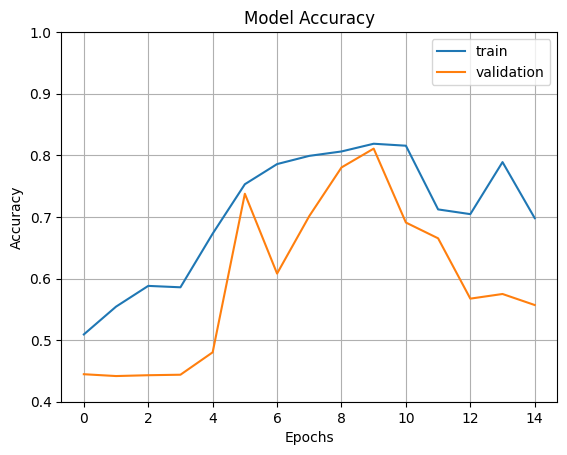

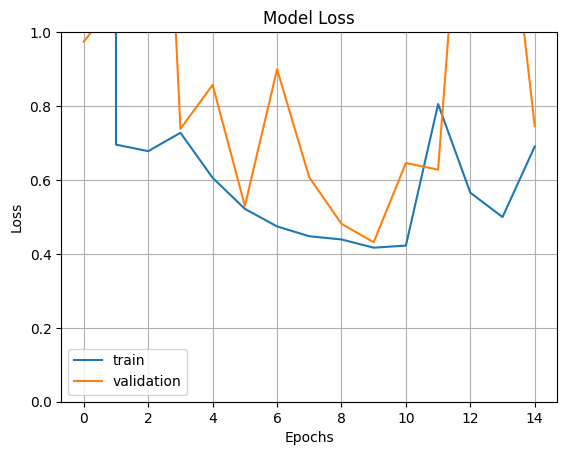

In [8]:
train_generator =  CSET3_generator
validation_generator = SET1_generator

rebuild_model()

steps_per_epoch = train_generator.labels.shape[0]//BATCH_SIZE
validation_steps = validation_generator.labels.shape[0]//BATCH_SIZE

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=30, 
                    validation_data=validation_generator, validation_steps=validation_steps, callbacks = [early_stopping])

results = model.evaluate(test_generator)
print("test loss, test acc:", results)

fig = plt.gcf()
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

2023-03-21 20:08:48.526127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 32 feature_map_count: 3 spatial: 256 256  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 64 input_feature_map_count: 3 layout: OutputInputYX shape: 7 7 }
  {zero_padding: 3 3  pad_alignment: default filter_strides: 2 2  dilation_rates: 1 1 }
  ... because it uses an identity activation.
2023-03-21 20:08:48.558227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:5340] Disabling cuDNN frontend for the following convolution:
  input: {count: 32 feature_map_count: 64 spatial: 64 64  value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}
  filter: {output_feature_map_count: 256 input_feature_map_count: 64 layout: OutputInputYX shape: 1 1 }
  {zero_padding: 0 0  pad_alignment: default filter_strides: 1 1  dilation_rates: 1 1 }
  ... because it uses an identity

4/4 [==============================] - 3s 29ms/step


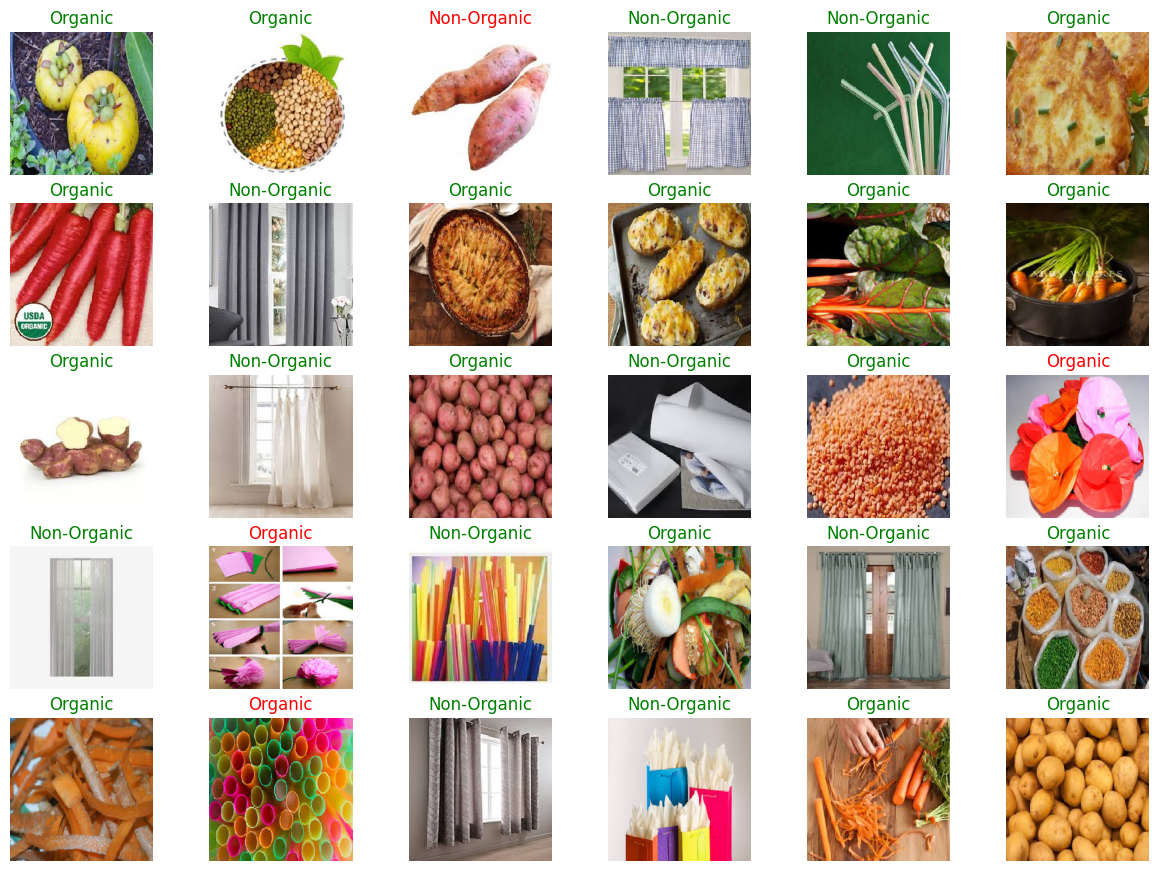

In [9]:
img, _= next(test_generator)
plt.figure(figsize=(15, 13))
result = model.predict(img)
for i in range(30):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(img[i])
    if result[i][1] < 0.5:
        pred = 0
        if pred == _[i][1]:
            plt.title("Organic", color='green')
        else: 
            plt.title("Organic", color='red')
    else:
        pred = 1
        if pred == _[i][1]:
            plt.title("Non-Organic", color='green')
        else: 
            plt.title("Non-Organic", color='red')
    plt.axis("off")